# Predicción de la demanda de alquiler de bicicletas en Washington D.C.

El dataset utilizado contiene la demanda por hora para los años 2011 y 2012 del sistema de alquiler de bicicletas. También contiene datos del clima como Temperatura, Precipitación y Velocidad del Viento para cada hora.

Actualmente existe gran interes en este sistema de transporte debido a sus beneficios en el descongestionamiento del tráfico, cambio climático y efectos en la salud de los usuarios. Monitorear y estimar la demanda de estos sistemas puede ayudar a la gestión pública enfocada en la mobilidad urbana.

Fuente: https://www.kaggle.com/datasets/lakshmi25npathi/bike-sharing-dataset?select=hour.csv

# Descarga de Datos

In [1]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

#autenticación de credenciales google
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

#mi archivo en drive
fileDownloaded = drive.CreateFile({'id':'1it7U8mTFe8Zaxxk2ZOsabCu6Wytjloff'})

#bajar contenido a colab
fileDownloaded.GetContentFile('bike_share.zip')

In [2]:
! unzip /content/bike_share.zip

Archive:  /content/bike_share.zip
  inflating: hour.csv                


In [3]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [4]:
df = pd.read_csv('hour.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  casual      17379 non-null  int64  
 15  registered  17379 non-null  int64  
 16  cnt         17379 non-null  int64  
dtypes: float64(4), int64(12), object(1)
memory usage: 2.3+ MB


Creamos un campo que identifique la fecha y la hora del registro y eliminamos las columnas que no aportan valor al modelo

# Limpieza de Datos

In [5]:
df['date_hour'] = df['dteday']+' '+df['hr'].astype(str)
df['date_hour'] = df['date_hour'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d %H'))
df.drop(columns = ['instant', 'dteday', 'casual', 'registered', 'atemp'], inplace = True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   season      17379 non-null  int64         
 1   yr          17379 non-null  int64         
 2   mnth        17379 non-null  int64         
 3   hr          17379 non-null  int64         
 4   holiday     17379 non-null  int64         
 5   weekday     17379 non-null  int64         
 6   workingday  17379 non-null  int64         
 7   weathersit  17379 non-null  int64         
 8   temp        17379 non-null  float64       
 9   hum         17379 non-null  float64       
 10  windspeed   17379 non-null  float64       
 11  cnt         17379 non-null  int64         
 12  date_hour   17379 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(3), int64(9)
memory usage: 1.7 MB


In [6]:
vars_to_normalize = ['season', 'yr', 'mnth', 'hr', 'holiday', 'weekday', 'workingday', 'weathersit', 'cnt'] 
# normaliza
for c in vars_to_normalize:
    df[c] = (df[c] - df[c].min()) / (df[c].max() - df[c].min())

df.head()

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,date_hour
0,0.0,0.0,0.0,0.000000,0.0,1.0,0.0,0.0,0.24,0.81,0.0,0.015369,2011-01-01 00:00:00
1,0.0,0.0,0.0,0.043478,0.0,1.0,0.0,0.0,0.22,0.80,0.0,0.039959,2011-01-01 01:00:00
2,0.0,0.0,0.0,0.086957,0.0,1.0,0.0,0.0,0.22,0.80,0.0,0.031762,2011-01-01 02:00:00
3,0.0,0.0,0.0,0.130435,0.0,1.0,0.0,0.0,0.24,0.75,0.0,0.012295,2011-01-01 03:00:00
4,0.0,0.0,0.0,0.173913,0.0,1.0,0.0,0.0,0.24,0.75,0.0,0.000000,2011-01-01 04:00:00


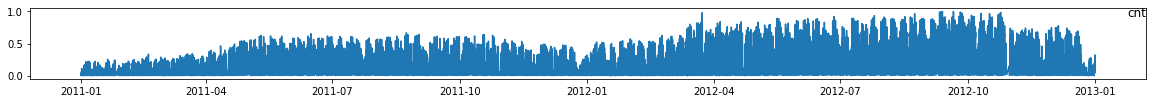

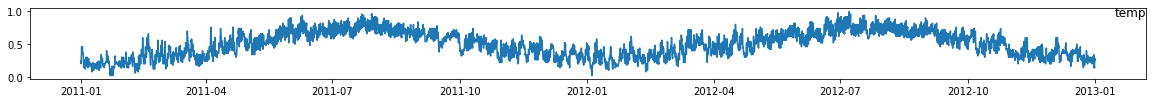

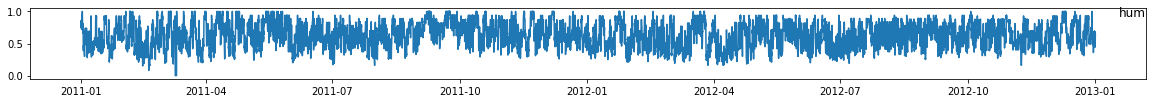

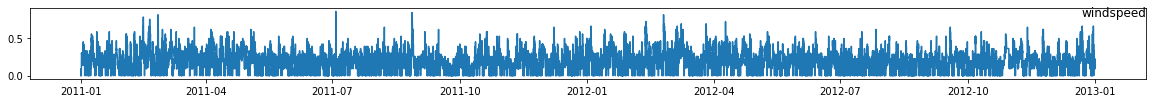

In [7]:
for i, c in enumerate(['cnt', 'temp', 'hum', 'windspeed']):
    plt.figure(figsize=(20, 20))
    plt.subplot(df.columns.size, 1, i+1)
    plt.plot(df['date_hour'], df[c])    
    plt.title(c, y=0.8, loc='right')    
    plt.show()

In [8]:
train = df[df['date_hour'] < '2012-08-01']
test  = df[df['date_hour'] >= '2012-08-01']
train.shape, test.shape

((13747, 13), (3632, 13))

In [9]:
cols = df.columns.drop(['date_hour']) 

def set_window(train_df = train, test_df = test, window_size = 3):

  X_tr = pd.concat([pd.concat([train_df[c].shift(w, fill_value=0) for w in range(1, window_size+1)], axis=1, keys=[f"{c}_{w}" for w in range(1, window_size+1)]) for c in cols], axis=1)
  X_ts  = pd.concat([pd.concat([test_df[c].shift(w, fill_value=0) for w in range(1, window_size+1)], axis=1, keys=[f"{c}_{w}" for w in range(1, window_size+1)]) for c in cols], axis=1)

  y_tr = train_df['cnt']
  y_ts  = test_df['cnt']

  X_tr = X_tr.values.reshape( (X_tr.shape[0], X_tr.shape[1], 1) )
  X_ts  = X_ts.values.reshape( (X_ts.shape[0], X_tr.shape[1], 1) )

  return X_tr, y_tr, X_ts, y_ts


# Modelos

## Model 1
Window size de 12
Capa LSTM de 24*30 y otra capa de 3

In [10]:
X_train, y_train, X_test, y_test = set_window(window_size = 12)

X_train.shape, X_test.shape

((13747, 144, 1), (3632, 144, 1))

In [18]:
model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[X_train.shape[1], X_train.shape[2]]),
    
    # capas de LSTM
    tf.keras.layers.LSTM(24*30, return_sequences=True), # 24 horas x 30 días
    tf.keras.layers.LSTM(3), # 3 meses...
    
    # capas densas
    #tf.keras.layers.Dense(30, activation='relu'),    
    tf.keras.layers.Dense(1, activation='linear'),
 ])
    
model.compile(loss="mean_squared_error", optimizer="adam")
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=50, verbose=True)

Epoch 1/15
275/275 [==============================] - 18s 56ms/step - loss: 0.0245 - val_loss: 0.0446
Epoch 2/15
275/275 [==============================] - 15s 56ms/step - loss: 0.0154 - val_loss: 0.0155
Epoch 3/15
275/275 [==============================] - 15s 55ms/step - loss: 0.0087 - val_loss: 0.0130
Epoch 4/15
275/275 [==============================] - 15s 55ms/step - loss: 0.0068 - val_loss: 0.0106
Epoch 5/15
275/275 [==============================] - 16s 57ms/step - loss: 0.0063 - val_loss: 0.0106
Epoch 6/15
275/275 [==============================] - 15s 54ms/step - loss: 0.0058 - val_loss: 0.0097
Epoch 7/15
275/275 [==============================] - 15s 53ms/step - loss: 0.0052 - val_loss: 0.0099
Epoch 8/15
275/275 [==============================] - 15s 54ms/step - loss: 0.0049 - val_loss: 0.0089
Epoch 9/15
275/275 [==============================] - 15s 54ms/step - loss: 0.0041 - val_loss: 0.0078
Epoch 10/15
275/275 [==============================] - 15s 54ms/step - loss: 0.003

In [19]:
# predicciones
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
# RMSE
np.sqrt(np.mean((test_predict.flatten() - y_test)**2))

0.06960834685357847

## Model 2

Incrementamos Window size a 24

In [21]:
X_train2, y_train2, X_test2, y_test2 = set_window(window_size = 24)

model2 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[X_train2.shape[1], X_train2.shape[2]]),
    
    # capas de LSTM
    tf.keras.layers.LSTM(24*30, return_sequences=True), # 24 horas x 30 días
    tf.keras.layers.LSTM(3), # 3 meses...

    # capas densas
    #tf.keras.layers.Dense(30, activation='relu'),    
    tf.keras.layers.Dense(1, activation='linear'),
 ])
    
model2.compile(loss="mean_squared_error", optimizer="adam")
history2 = model2.fit(X_train2, y_train2, validation_data=(X_test2, y_test2), epochs=15, batch_size=50, verbose=True)

Epoch 1/15
275/275 [==============================] - 32s 108ms/step - loss: 0.0141 - val_loss: 0.0203
Epoch 2/15
275/275 [==============================] - 30s 108ms/step - loss: 0.0089 - val_loss: 0.0136
Epoch 3/15
275/275 [==============================] - 29s 105ms/step - loss: 0.0074 - val_loss: 0.0130
Epoch 4/15
275/275 [==============================] - 29s 106ms/step - loss: 0.0068 - val_loss: 0.0134
Epoch 5/15
275/275 [==============================] - 29s 106ms/step - loss: 0.0064 - val_loss: 0.0095
Epoch 6/15
275/275 [==============================] - 29s 107ms/step - loss: 0.0055 - val_loss: 0.0095
Epoch 7/15
275/275 [==============================] - 29s 106ms/step - loss: 0.0052 - val_loss: 0.0089
Epoch 8/15
275/275 [==============================] - 29s 107ms/step - loss: 0.0048 - val_loss: 0.0105
Epoch 9/15
275/275 [==============================] - 29s 107ms/step - loss: 0.0045 - val_loss: 0.0078
Epoch 10/15
275/275 [==============================] - 29s 106ms/step - l

In [22]:
# predicciones
train_predict2 = model2.predict(X_train2)
test_predict2 = model2.predict(X_test2)
# RMSE
np.sqrt(np.mean((test_predict2.flatten() - y_test2)**2))

0.07491189195933132

## Model 3
Incremento de Neuronas en capa LSTM 

In [28]:
model3 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[X_train.shape[1], X_train.shape[2]]),
    
    # capas de LSTM
    tf.keras.layers.LSTM(24, return_sequences=True), # 24 horas x 30 días
    tf.keras.layers.LSTM(30*3), # 3 meses...
    # capas densas
    #tf.keras.layers.Dense(30, activation='relu'),    
    tf.keras.layers.Dense(1, activation='linear'),
 ])
    
model3.compile(loss="mean_squared_error", optimizer="adam")
history3 = model3.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=15, batch_size=50, verbose=True)

Epoch 1/15
275/275 [==============================] - 7s 16ms/step - loss: 0.0235 - val_loss: 0.0321
Epoch 2/15
275/275 [==============================] - 4s 14ms/step - loss: 0.0159 - val_loss: 0.0257
Epoch 3/15
275/275 [==============================] - 4s 14ms/step - loss: 0.0143 - val_loss: 0.0248
Epoch 4/15
275/275 [==============================] - 4s 14ms/step - loss: 0.0123 - val_loss: 0.0190
Epoch 5/15
275/275 [==============================] - 5s 17ms/step - loss: 0.0097 - val_loss: 0.0138
Epoch 6/15
275/275 [==============================] - 4s 14ms/step - loss: 0.0074 - val_loss: 0.0106
Epoch 7/15
275/275 [==============================] - 5s 17ms/step - loss: 0.0058 - val_loss: 0.0080
Epoch 8/15
275/275 [==============================] - 6s 23ms/step - loss: 0.0048 - val_loss: 0.0073
Epoch 9/15
275/275 [==============================] - 4s 14ms/step - loss: 0.0041 - val_loss: 0.0069
Epoch 10/15
275/275 [==============================] - 4s 14ms/step - loss: 0.0037 - val_lo

In [32]:
# predicciones
train_predict3 = model3.predict(X_train)
test_predict3 = model3.predict(X_test)
# RMSE
np.sqrt(np.mean((test_predict3.flatten() - y_test)**2))

0.07517681069361688

## Model 4
Igual al model 1 pero con mas epochs

In [30]:
model4 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[X_train.shape[1], X_train.shape[2]]),
    
    # capas de LSTM
    tf.keras.layers.LSTM(24*30, return_sequences=True), # 24 horas x 30 días
    tf.keras.layers.LSTM(3), # 3 meses...
    
    # capas densas
    #tf.keras.layers.Dense(30, activation='relu'),    
    tf.keras.layers.Dense(1, activation='linear'),
 ])

model4.compile(loss="mean_squared_error", optimizer="adam")
history4 = model4.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=50, verbose=True)

Epoch 1/25
275/275 [==============================] - 18s 56ms/step - loss: 0.0229 - val_loss: 0.0283
Epoch 2/25
275/275 [==============================] - 16s 58ms/step - loss: 0.0199 - val_loss: 0.0291
Epoch 3/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0124 - val_loss: 0.0165
Epoch 4/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0080 - val_loss: 0.0122
Epoch 5/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0063 - val_loss: 0.0114
Epoch 6/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0056 - val_loss: 0.0110
Epoch 7/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0047 - val_loss: 0.0064
Epoch 8/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0040 - val_loss: 0.0073
Epoch 9/25
275/275 [==============================] - 15s 56ms/step - loss: 0.0037 - val_loss: 0.0080
Epoch 10/25
275/275 [==============================] - 15s 55ms/step - loss: 0.003

In [33]:
# predicciones
train_predict4 = model4.predict(X_train)
test_predict4 = model4.predict(X_test)
# RMSE
np.sqrt(np.mean((test_predict4.flatten() - y_test)**2))

0.062129971846012405

## Model 5
Incrementando segunda capa LSTM

In [34]:
model5 = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=[X_train.shape[1], X_train.shape[2]]),
    
    # capas de LSTM
    tf.keras.layers.LSTM(24*30, return_sequences=True), # 24 horas x 30 días
    tf.keras.layers.LSTM(12), # 12 meses...
    
    # capas densas
    #tf.keras.layers.Dense(30, activation='relu'),    
    tf.keras.layers.Dense(1, activation='linear'),
 ])

model5.compile(loss="mean_squared_error", optimizer="adam")
history5 = model5.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=25, batch_size=50, verbose=True)

Epoch 1/25
275/275 [==============================] - 18s 58ms/step - loss: 0.0197 - val_loss: 0.0247
Epoch 2/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0102 - val_loss: 0.0133
Epoch 3/25
275/275 [==============================] - 15s 55ms/step - loss: 0.0073 - val_loss: 0.0119
Epoch 4/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0061 - val_loss: 0.0114
Epoch 5/25
275/275 [==============================] - 15s 53ms/step - loss: 0.0056 - val_loss: 0.0101
Epoch 6/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0051 - val_loss: 0.0087
Epoch 7/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0044 - val_loss: 0.0065
Epoch 8/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0040 - val_loss: 0.0071
Epoch 9/25
275/275 [==============================] - 15s 54ms/step - loss: 0.0036 - val_loss: 0.0060
Epoch 10/25
275/275 [==============================] - 15s 54ms/step - loss: 0.003

In [35]:
# predicciones
train_predict5 = model5.predict(X_train)
test_predict5 = model5.predict(X_test)
# RMSE
np.sqrt(np.mean((test_predict5.flatten() - y_test)**2))

0.05638996048688624

## Mejor Modelo

Aumentar el número de Neuronas en la capa LSTM incrementa los tiempos de ejecución y no mejora el modelo. Igualmente incrementar el window size no hizo que mejorara el modelo. El número de epochs óptimo pareciera ser 25. El modelo también mejoró considerablemente cuando aumentamos las neuronas de la 2da capa LSTM

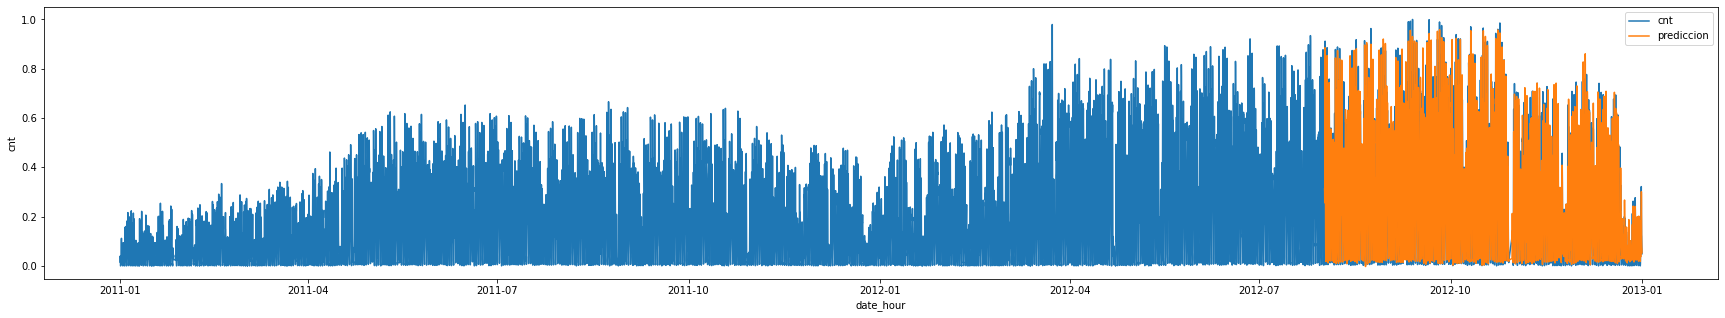

In [36]:
plt.figure(figsize=(30, 5))
plt.plot(df['date_hour'], df['cnt'], label="cnt")
plt.plot(test['date_hour'][12:], test_predict5[12:], label="prediccion")
plt.xlabel("date_hour")
plt.ylabel("cnt")
plt.legend()
plt.show()